# Experiment -- Nystroem

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.kernel_approximation import Nystroem #Nystroem
import torch

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
df=df.iloc[:1000]
train,test = train_test_split(df, train_size=0.7,random_state=1)
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
train_x ##display the data

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
731,39.93176,43.28746,-13.38596,11.97077,39.47386,-15.98213,0.40450,-0.12974,4.93046,8.47701,...,9.28421,-125.31252,0.10776,112.07104,0.58354,128.69854,-37.50035,4.97255,-73.38973,-5.31664
716,46.74950,53.94547,25.02572,5.29242,-36.49030,-2.30921,-0.88374,7.94827,2.77896,5.21121,...,-6.69378,-114.22822,170.00155,5.53618,-12.34778,18.59814,-34.67413,6.49130,-49.10779,-2.61190
640,26.02330,-201.77563,-128.76849,26.31990,63.19943,-33.42568,-20.38217,-15.65645,35.54939,21.00675,...,20.10206,-13.31202,-22.88050,99.55618,6.30266,-105.03800,57.34783,9.21763,-205.96332,21.07824
804,47.80721,25.07585,33.84950,8.05847,-22.52360,3.74708,-21.39957,-14.34260,24.15216,2.84670,...,3.71892,-203.19986,-12.75812,14.11742,-8.29798,-73.19181,-158.66941,-3.79311,-180.22609,-12.45983
737,40.19555,22.55823,-22.31865,-16.40915,20.24315,-25.18230,-1.08735,-2.01056,9.99175,9.27890,...,8.87001,-58.76444,-60.51858,81.75608,-1.32502,36.14569,33.95389,6.52971,25.39161,8.16208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,45.93913,19.88129,51.47329,44.70062,7.87333,38.07456,10.32526,-15.60014,15.21450,-8.71651,...,16.54059,-128.53880,251.82840,22.90044,11.47945,145.29346,46.63635,33.09373,-248.67078,0.35662
72,48.61503,60.89685,-4.13356,7.76381,-6.11871,-14.68743,11.85668,8.17211,6.15722,7.37379,...,-14.75838,6.07177,41.87603,-70.27975,-13.59340,13.63338,73.66982,11.31753,55.91604,-0.60016
908,52.08806,41.42045,24.18691,-7.90194,-7.97742,-27.57139,11.58830,0.34746,1.19699,-0.69531,...,2.51542,23.88389,18.32899,-24.27133,7.22198,-15.91165,-29.66592,2.09806,38.53232,0.92214
235,31.84167,-89.55516,47.90171,1.36908,-19.85127,38.35041,-36.09192,12.50563,4.25735,9.29543,...,37.36157,-586.29171,120.67061,234.89404,-56.33737,-195.16410,262.17781,-18.54742,57.71193,23.59455


## SVR

In [44]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": np.logspace(0, 2, 10), "gamma": np.logspace(-2, 0, 10)},
)

t0 = time.time()
svr.fit(train_x, train_y)
svr_fit = time.time() - t0
y_svr=svr.predict(test_x)
svrmse=mean_squared_error(test_y,y_svr)
print(f"Best SVR with params: {svr.best_params_}")
print(f"testMSE: {svrmse:.3f}")
y_svr=svr.predict(train_x)
svrmse=mean_squared_error(train_y,y_svr)
print(f"trainMSE: {svrmse:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

Best SVR with params: {'C': 100.0, 'gamma': 0.01}
testMSE: 178.359
trainMSE: 0.010
SVR complexity and bandwidth selected and model fitted in 24.797 s


## DNN

In [333]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

In [27]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(5, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.8) #optim.Adam(...)

dnn_trainloss=[]
dnn_testloss=[]
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        dnn_trainloss.append(float(train_loss))
        dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 342625.46875
            Test  set - loss: 243909.921875
            
epoch 10
            Train set - loss: 188.890625
            Test  set - loss: 104.49170684814453
            
epoch 20
            Train set - loss: 116.5293197631836
            Test  set - loss: 106.81121826171875
            
epoch 30
            Train set - loss: 148.6772918701172
            Test  set - loss: 106.59915161132812
            
epoch 40
            Train set - loss: 280.8228454589844
            Test  set - loss: 105.52947235107422
            
epoch 50
            Train set - loss: 205.85797119140625
            Test  set - loss: 106.37751007080078
            
epoch 60
            Train set - loss: 211.4290008544922
  

## One kernel machine for different number of Nystroem

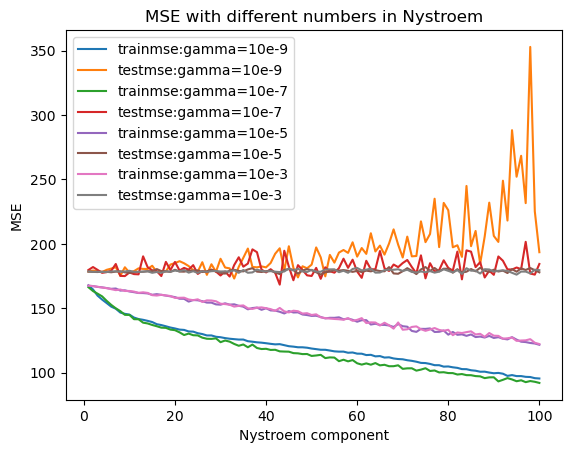

In [ ]:
model =LinearRegression()
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
gaset=np.logspace(-9,-3,4)
n0=64

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=ga,n_components=m0)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            model.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=model.predict(test_xtransformed)
                yl_kltrain=model.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+model.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+model.predict(train_xtransformed) 
        
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_krtrain))
        testmse.append(mean_squared_error(test_y,y_kr))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse)
    

plt.xlabel("Nystroem component")
plt.ylabel("MSE")
plt.title("MSE with different numbers in Nystroem")
plt.legend(["trainmse:gamma=10e-9","testmse:gamma=10e-9","trainmse:gamma=10e-7","testmse:gamma=10e-7","trainmse:gamma=10e-5","testmse:gamma=10e-5","trainmse:gamma=10e-3","testmse:gamma=10e-3"])
plt.show()

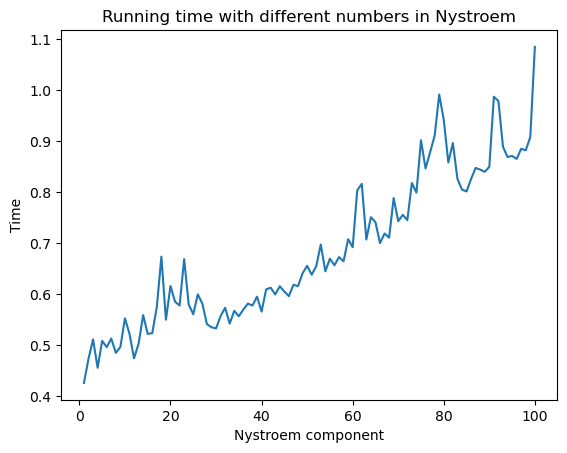

In [ ]:
model =LinearRegression()
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
n0=64
trainmse=[]
testmse=[]
t=[]
for m0 in m0set:
    t0 = time.time()
    for i in range(n0):
        feature_map_nystroem = Nystroem(gamma=0.00001,n_components=m0)
        train_xtransformed = feature_map_nystroem.fit_transform(train_x)
        test_xtransformed = feature_map_nystroem.fit_transform(test_x)
        model.fit(train_xtransformed, train_y)
        if i==0:
            yl_kr=model.predict(test_xtransformed)
            yl_kltrain=model.predict(train_xtransformed)
        else:
            yl_kr=yl_kr+model.predict(test_xtransformed)
            yl_kltrain=yl_kltrain+model.predict(train_xtransformed) 
    y_kr=yl_kr/n0
    y_krtrain=yl_kltrain/n0
    kernel_fit = time.time() - t0
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(m0set,t)
plt.xlabel("Nystroem component")
plt.ylabel("Time")
plt.title("Running time with different numbers in Nystroem")
plt.show()

## kernel machine 1 - network learning

single hidden layer

In [35]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(90, 10)
        self.fc2 = nn.Linear(10, 1)
 
    def forward(self, x):
        feature_map_nystroem = Nystroem(gamma=0.1,n_components=10)
        y=self.fc1(x).detach().numpy()
        yn = feature_map_nystroem.fit_transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc2(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.8) #optim.Adam(...)

onenn_trainloss=[]
onenn_testloss=[]


for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        onenn_trainloss.append(float(train_loss))
        onenn_testloss.append(float(test_loss))

dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=90, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 335889.5625
            Test  set - loss: 241058.8125
            
epoch 10
            Train set - loss: 578.31005859375
            Test  set - loss: 217.4813995361328
            
epoch 20
            Train set - loss: 409.51397705078125
            Test  set - loss: 248.61611938476562
            
epoch 30
            Train set - loss: 319.23480224609375
            Test  set - loss: 148.15309143066406
            
epoch 40
            Train set - loss: 230.76707458496094
            Test  set - loss: 124.77001953125
            
epoch 50
            Train set - loss: 199.51882934570312
            Test  set - loss: 130.7213134765625
            
epoch 60
            Train set - loss: 91.62682342529297
            Test  set - loss: 121.44302368164062
            
epoch 70
            Train set - loss: 282.952697753

multi layer

In [349]:
import torch
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(5, 1)
 
    def forward(self, x):
        feature_map_nystroem = Nystroem(gamma=10**(-1),n_components=50)
        y=self.fc1(x).detach().numpy()
        yn = feature_map_nystroem.fit_transform(y)
        x = torch.from_numpy(yn).float()
        feature_map_nystroem = Nystroem(gamma=10**(-2),n_components=20)
        y=self.fc2(x).detach().numpy()
        yn = feature_map_nystroem.fit_transform(y)
        x = torch.from_numpy(yn).float()
        feature_map_nystroem = Nystroem(gamma=10**(-3),n_components=5)
        y=self.fc3(x).detach().numpy()
        yn = feature_map_nystroem.fit_transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.8) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]

for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        kernelnn_trainloss.append(float(train_loss))
        kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 2719954.25
            Test  set - loss: 2618349.5
            
epoch 10
            Train set - loss: 5537.00146484375
            Test  set - loss: 5905.23046875
            
epoch 20
            Train set - loss: 137.56382751464844
            Test  set - loss: 141.92279052734375
            
epoch 30
            Train set - loss: 150.08746337890625
            Test  set - loss: 112.18441772460938
            
epoch 40
            Train set - loss: 91.21588897705078
            Test  set - loss: 110.79844665527344
            
epoch 50
            Train set - loss: 151.5063018798828
            Test  set - loss: 104.3828125
            
epoch 60
            Train set - loss: 203.57789611816406
      

Comparing different network

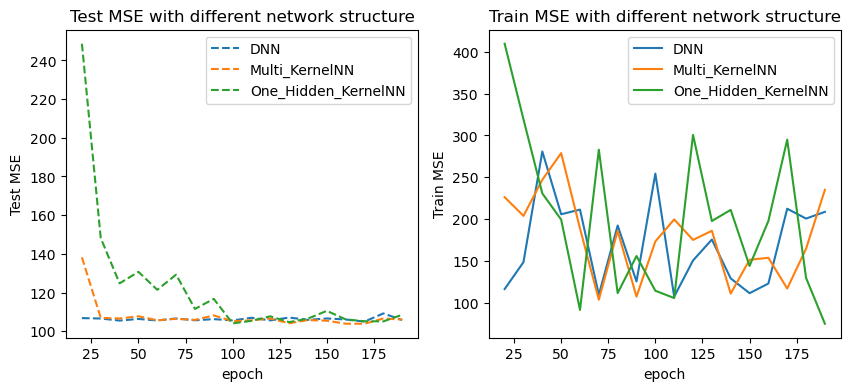

In [51]:
a=np.linspace(2,19,18)
epochset = [int(item*10) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,dnn_testloss[2:],linestyle='dashed')
ax[0].plot(epochset,kernelnn_testloss[2:],linestyle='dashed')
ax[0].plot(epochset,onenn_testloss[2:],linestyle='dashed')
ax[0].legend(["DNN","Multi_KernelNN","One_Hidden_KernelNN"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different network structure")

ax[1].plot(epochset,dnn_trainloss[2:])
ax[1].plot(epochset,kernelnn_trainloss[2:])
ax[1].plot(epochset,onenn_trainloss[2:])
ax[1].legend(["DNN","Multi_KernelNN","One_Hidden_KernelNN"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different network structure")
plt.show()


## kernel machine 2 - residual learning

different layer

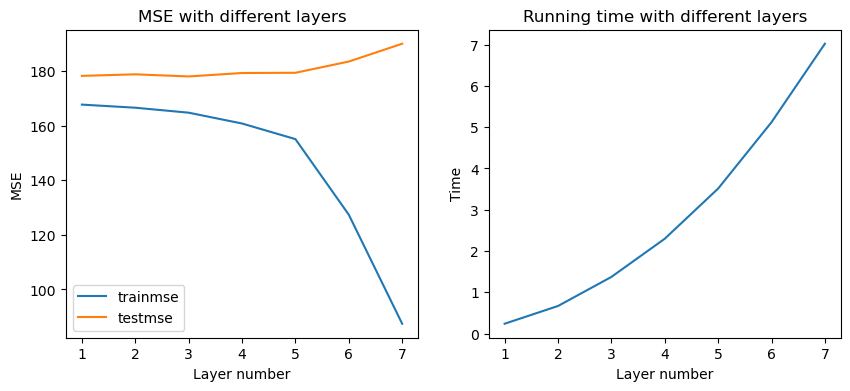

In [34]:
model = LinearRegression()
layerset=np.linspace(1,7,7)
layerset=layerset.astype(int)
m0=1
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/10**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                model.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/10**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                model.fit(train_xtransformed, train_y-y_krtrain) ##fit residual
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()

data splitting

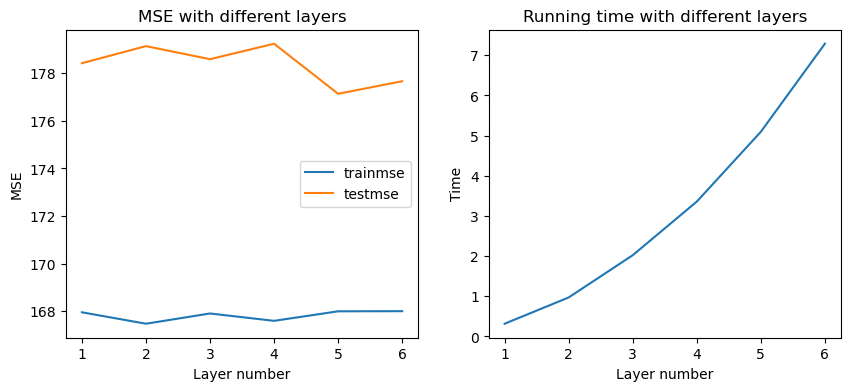

In [32]:
model = LinearRegression()
layerset=np.linspace(1,6,6)
layerset=layerset.astype(int)
m0=1
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    length=int(len(train_x)/layer)
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/10**l,n_components=m0*2**l)
                train_xltransformed = feature_map_nystroem.fit_transform(train_x[l*length:(l+1)*length])
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length])
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/10**l,n_components=m0*2**l)
                train_xltransformed = feature_map_nystroem.fit_transform(train_x[l*length:(l+1)*length])
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length]-y_krtrain[l*length:(l+1)*length]) ##fit residual
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()